# Network Slimming
- Pruning via L1 on Batchnorm Gammas
- Based on "Learning Efficient Convolutional Networks through Network Slimming"
- CIFAR100 and VGG16
- Soft (setting bn params to 0) and Hard (chaning architecture) pruning strategies
- Depending on location 50% filter pruning results in 80% of weights pruned
- lr schedule, weight init and hyperparams as in paper
- For 50% pruning can't get same 73% perf. always 1% lower

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import vgg16_bn
from torchvision.datasets import CIFAR100

import math
import copy
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

DATASET_ROOT = "/data/datasets/CIFAR100"

In [2]:
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]),
    ]
)


def get_loaders(batch_size=512):
    train_ds = CIFAR100(root=DATASET_ROOT, transform=train_transform, train=True)
    test_ds = CIFAR100(root=DATASET_ROOT, transform=test_transform, train=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

    return train_loader, test_loader


In [3]:
def get_model():
    model = vgg16_bn(pretrained=False)
    model.features = model.features[:-1] # dropping the last maxpool
    model.avgpool = nn.AvgPool2d(kernel_size=2)
    model.classifier = nn.Sequential(nn.Linear(512, 100))
    
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias = None
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(0.5)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
    
    return model


def get_bn_l1_loss(model):
    """L1 reg loss for bn gamma"""
    loss = 0
    for layer in model.features:
        if isinstance(layer, nn.BatchNorm2d):
            loss += layer.weight.abs().sum()
    return loss

In [4]:
def evaluate(model, loader) -> float:
    """Get Accuracy"""
    correct = 0
    n_obs = 0
    
    model.eval()
    for X, y in loader:
        X, y = X.cuda(), y.cuda()
        with torch.no_grad():
            out = model(X)
        correct += (out.argmax(dim=1) == y).float().sum()
        n_obs += len(X)
    model.train()    
    
    accuracy = correct / n_obs
    return accuracy.item()


def train(model, n_epochs=160, lr=1e-1, batch_size=512, bn_l1_weight=1e-4):
    """
    :param inital_lr: for finetuning to continue cosine annealing
    :param max_epochs: will stop at n_epochs but max_epochs is needed for scheduling
    :param last_epoch: when finetuning need to specify at what epoch previously stopped
    """
    model = copy.deepcopy(model).cuda().train()
    train_loader, test_loader = get_loaders(batch_size)
    logs = defaultdict(list)
    criterion = nn.CrossEntropyLoss()
    # Don't as me why but the original implementation uses l1 on top of the l2 for the whole model
    optimiser = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=1e-4)
    
    milestones = [int(n_epochs * .5), int(n_epochs * .75)]
    print(f"Reducing LR at: {milestones}")
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimiser, milestones=milestones, gamma=0.1)
    
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        for X, y in train_loader:
            X, y = X.cuda(), y.cuda()
            out = model(X)
            loss = criterion(out, y) + bn_l1_weight * get_bn_l1_loss(model)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        lr_scheduler.step()
        #logs["train_acc"].append(evaluate(model, train_loader))
        logs["lr"].append(optimiser.state_dict()["param_groups"][0]["lr"])
        logs["test_acc"].append(evaluate(model, test_loader))
        pbar.set_description("Test Acc: {:.4f}%".format(logs['test_acc'][-1] * 100))
    return model, logs


In [5]:
model = get_model()
trained_model, trained_logs = train(model, n_epochs=160, batch_size=64, bn_l1_weight=1e-4)

  0%|          | 0/160 [00:00<?, ?it/s]

Reducing LR at: [80, 120]


Test Acc: 73.6600%: 100%|██████████| 160/160 [49:44<00:00, 18.65s/it]


0.7365999817848206

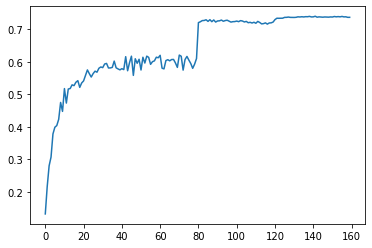

In [6]:
plt.plot(trained_logs["test_acc"])
trained_logs["test_acc"][-1]

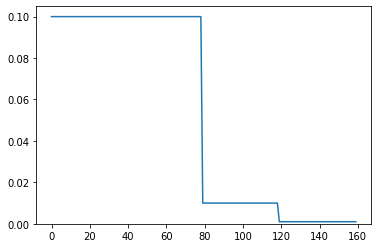

In [7]:
plt.plot(trained_logs["lr"])
plt.ylim(bottom=0)
plt.show()

In [8]:
def get_gammas(model, cat=False):
    """
    Get the gamma parameters of the bn layers
    :param cat: whether to concatenate and all gammas into one tensor.
    """
    res = [bn.weight.view(-1).detach().cpu() for bn in model.modules() if isinstance(bn, nn.BatchNorm2d)]
    if cat:
        res = torch.cat(res)
    return res


def get_prune_masks(model, percentage=0.5, min_filters_per_layer: int=1) -> list:
    """Reuturns a list of masks of which filters to keep"""
    res = []
    threshold = np.quantile(get_gammas(model, cat=True).abs(), percentage)
    bns = [layer for layer in model.modules() if isinstance(layer, nn.BatchNorm2d)]
    for bn in bns:
        local_threshold = threshold
        # leave at least min_filters_per_layer
        if (bn.weight.abs() >= local_threshold).float().sum() < min_filters_per_layer:
            local_threshold = bn.weight.abs().sort()[0][-min_filters_per_layer].item()
        mask = (bn.weight.abs() >= local_threshold).float().detach()  # filters to keep
        res.append(mask)
    return res


def count_filters(model, cat=True):
    gammas = get_gammas(model, cat=False)
    counts = [(l != 0).int().sum().item() for l in gammas]
    if cat == True:
        counts = sum(counts) 
    return counts

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Soft Pruning
- Just setting the BN params to 0, so the whole channel output will be 0 for that filter

In [9]:
def prune_soft(model, percentage=0.5, min_filters_per_layer: int=1):
    """Just set bn gamma and beta to 0 to produce 'unused' filters"""
    model = copy.deepcopy(model.cpu())
    masks = get_prune_masks(model, percentage, min_filters_per_layer)#[:-1]
    bns = [layer for layer in model.modules() if isinstance(layer, nn.BatchNorm2d)]#[:-1]
    for mask, bn in zip(masks, bns):
        with torch.no_grad():
            bn.weight.mul_(mask)
            bn.bias.mul_(mask)
    return model

Pruned Filters: 0.49644886363636365
Architecture: [30, 64, 118, 128, 253, 255, 255, 417, 181, 5, 5, 5, 411]


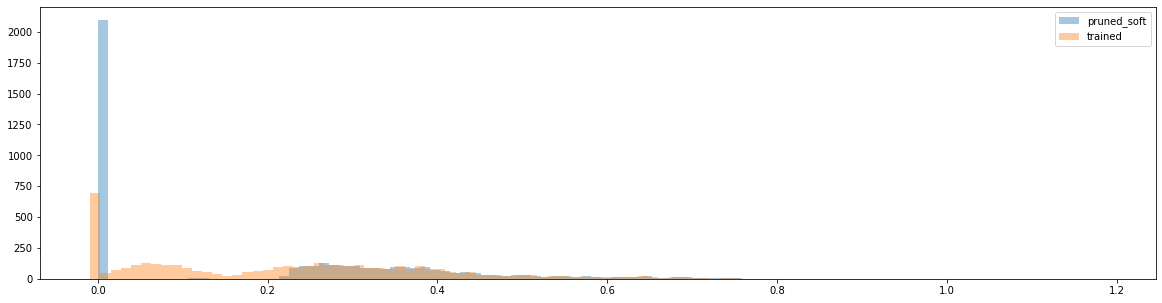

In [10]:
pruned_model_soft = prune_soft(trained_model, percentage=0.5, min_filters_per_layer=5)
print("Pruned Filters:", 1 - count_filters(pruned_model_soft) / count_filters(trained_model))
print("Architecture:", count_filters(pruned_model_soft, cat=False))

plt.figure(figsize=(20, 5))
sns.distplot(get_gammas(pruned_model_soft, cat=True), bins=100, kde=False, label="pruned_soft")
sns.distplot(get_gammas(trained_model, cat=True), bins=100, kde=False, label="trained")
plt.legend()
plt.show()

In [11]:
finetuned_model_soft, finetuned_logs_soft = train(pruned_model_soft, n_epochs=160, batch_size=64, bn_l1_weight=0)
print("Final Acc:", finetuned_logs_soft["test_acc"][-1])

  0%|          | 0/160 [00:00<?, ?it/s]

Reducing LR at: [80, 120]


Test Acc: 71.8000%: 100%|██████████| 160/160 [49:35<00:00, 18.59s/it]

Final Acc: 0.7179999947547913


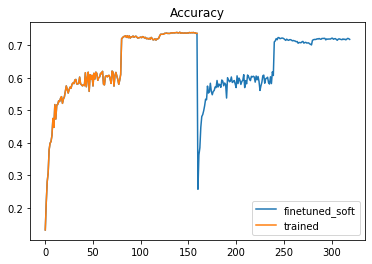

In [12]:
plt.title("Accuracy")
plt.plot(trained_logs["test_acc"] + finetuned_logs_soft["test_acc"], label="finetuned_soft")
plt.plot(trained_logs["test_acc"], label="trained")
plt.legend()
plt.show()

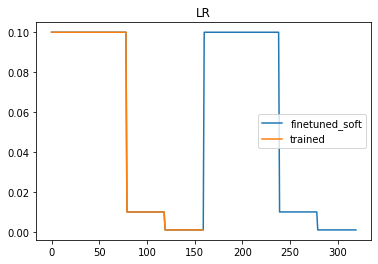

In [13]:
plt.title("LR")
plt.plot(trained_logs["lr"] + finetuned_logs_soft["lr"], label="finetuned_soft")
plt.plot(trained_logs["lr"], label="trained")
plt.legend()
plt.show()

# Hard Pruning
- Actually remove filters and weights by creating a new, pruned model

In [14]:
def prune_hard(model, percentage=0.5, min_filters_per_layer: int=1):
    """Create a new model with a pruned architecture"""
    model = copy.deepcopy(model.cpu())
    masks = get_prune_masks(model, percentage, min_filters_per_layer)
    
    mask_ix = 0
    with torch.no_grad():
        for layer_ix in range(len(model.features)):
            layer = model.features[layer_ix]
            if not isinstance(layer, (nn.Conv2d, nn.BatchNorm2d)):
                continue
            mask_as_indices = masks[mask_ix].nonzero().view(-1)
            if isinstance(layer, nn.Conv2d):
                previous_mask_as_indices = torch.tensor(range(layer.weight.shape[1])) if mask_ix == 0 else masks[mask_ix-1].nonzero().view(-1) 
                new_conv = nn.Conv2d(len(previous_mask_as_indices), len(mask_as_indices), kernel_size=layer.kernel_size, padding=layer.padding)
                new_conv.weight = nn.Parameter(layer.weight[mask_as_indices, :, :, :][:, previous_mask_as_indices, :, :])
                new_conv.bias = None if layer.bias is None else nn.Parameter(layer.bias[mask_as_indices])
                model.features[layer_ix] = new_conv
            if isinstance(layer, nn.BatchNorm2d):
                new_bn = nn.BatchNorm2d(len(mask_as_indices))
                new_bn.weight = nn.Parameter(layer.weight[mask_as_indices])
                new_bn.bias = nn.Parameter(layer.bias[mask_as_indices])
                new_bn.running_mean = layer.running_mean[mask_as_indices]
                new_bn.running_var = layer.running_var[mask_as_indices]
                model.features[layer_ix] = new_bn
                mask_ix += 1
        
        lin_mask = masks[-1].bool()
        old_lin = model.classifier[0]
        new_lin = nn.Linear(lin_mask.sum(), old_lin.out_features)
        new_lin.weight = nn.Parameter(old_lin.weight[:, lin_mask])
        new_lin.bias = nn.Parameter(old_lin.bias)
        model.classifier[0] = new_lin
    return model

Pruned Filter: 0.49644886363636365
Architecture: [30, 64, 118, 128, 253, 255, 255, 417, 181, 5, 5, 5, 411]


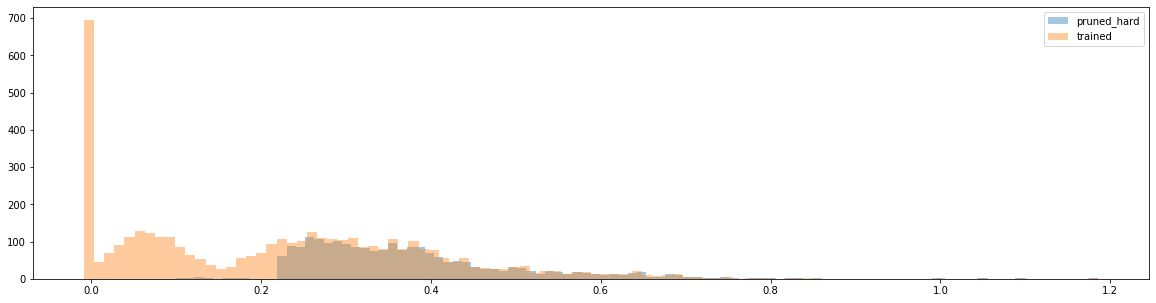

In [15]:
pruned_model_hard = prune_hard(trained_model, percentage=0.5, min_filters_per_layer=5)
print("Pruned Filter:", 1 - count_filters(pruned_model_hard) / count_filters(trained_model))
print("Architecture:", count_filters(pruned_model_hard, cat=False))

plt.figure(figsize=(20, 5))
sns.distplot(get_gammas(pruned_model_hard, cat=True), bins=100, kde=False, label="pruned_hard")
sns.distplot(get_gammas(trained_model, cat=True), bins=100, kde=False, label="trained")
plt.legend()
plt.show()

In [16]:
print("Pruned Parameters:", 1 - count_parameters(pruned_model_hard) / count_parameters(trained_model))

Pruned Parameters: 0.7706084381185592


In [17]:
finetuned_model_hard, finetuned_logs_hard = train(pruned_model_hard, n_epochs=160, batch_size=64, bn_l1_weight=0)
print("Final Acc:", finetuned_logs_hard["test_acc"][-1])

  0%|          | 0/160 [00:00<?, ?it/s]

Reducing LR at: [80, 120]


Test Acc: 71.7000%: 100%|██████████| 160/160 [33:09<00:00, 12.43s/it]

Final Acc: 0.7170000076293945


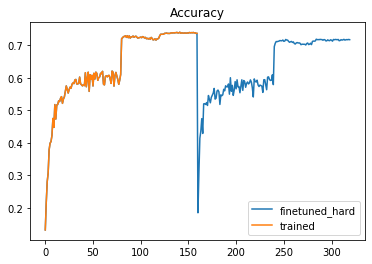

In [18]:
plt.title("Accuracy")
plt.plot(trained_logs["test_acc"] + finetuned_logs_hard["test_acc"], label="finetuned_hard")
plt.plot(trained_logs["test_acc"], label="trained")
plt.legend()
plt.show()

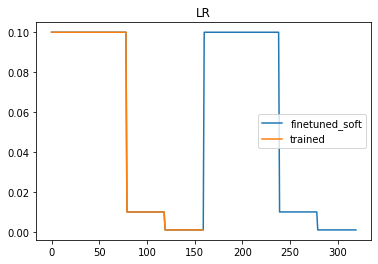

In [19]:
plt.title("LR")
plt.plot(trained_logs["lr"] + finetuned_logs_hard["lr"], label="finetuned_soft")
plt.plot(trained_logs["lr"], label="trained")
plt.legend()
plt.show()

In [20]:
finetuned_model_hard

VGG(
  (features): Sequential(
    (0): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 118, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(118, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(118, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati